In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | binary status if tree has died one year after fire event
| YrFireName                  | year and name of fire                           
| Times_burned                | number of times tree burned                                             
| Species                     | symbol for species. first two letters of genus and first two letters of species, sometimes followed by a number                                                    
| Genus_species               | Genus and species of tree                                      
| DBH_cm                      | diameter and breast height rounded to nearest 0.1
| HT_m                        | pre-fire tree height rounded to nearest 0.01 m
| CR_pre                      | pre-fire live crown ratio. crown length divided by tree height
| CR_post                     | post-fire live crown ratio. crown length divided by tree height

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')[['YrFireName', 'Species', 'Times_burned', 'yr1status', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']].dropna()
print(f"Observations left after removing NAs: {trees_dat.shape[0]}")

Observations left after removing NAs: 36509


/tmp/ipykernel_1396750/2769784280.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')[['YrFireName', 'Species', 'Times_burned', 'yr1status', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre', 'CR_post']].dropna()


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [3]:
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}_cat"] = trees_dat[col].astype('category').cat.codes


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [4]:
X = trees_dat.drop(['Species', 'Genus_species', 'YrFireName', 'yr1status'], axis=1)
y = trees_dat['yr1status']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test) 

3. How many training/test observations do we have? Print your answer in the cell below. 

In [5]:
train_obs = len(X_train_scaled)
test_obs = len(X_test_scaled)

# Verify the training and testing set size
print("Training set observations: ",train_obs )
print("Testing set observations:",test_obs)

Training set observations:  25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [6]:
# Train logistic regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred)}")

Training Accuracy: 0.945061825011739


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 0.9399251346663015 


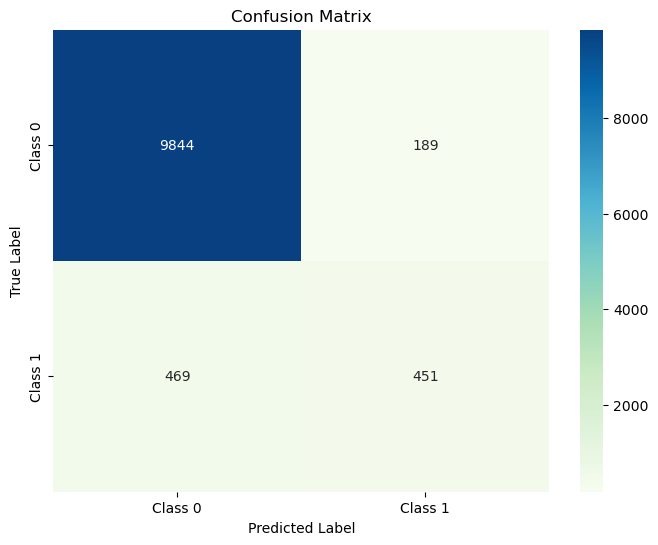

Ellipsis

In [7]:
y_test_pred = model.predict(X_test_scaled)
# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)} ")

#Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'GnBu',
xticklabels=['Class 0', 'Class 1'],
yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
...

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The model did pretty well on the unseen data. The accuracy which is determined by (TP + TN) / (TP + TN + FP + FN) was about 0.94. There is definitely a class imbalance, for there are many more alive trees (10,033) than dead (920). It performed better on trees that survived versus died. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

If we built a model that always predicts the majority class (alive trees), then the accuracy of the dummy model should be lower than the accuracy of the logistic regression. Even if a majority are actually alive, there are still some trees that should actually be label dead, so it's likely the dummy model will be less accurate.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Training Accuracy: 0.9172405697292221

Dummy Confusion Matrix:


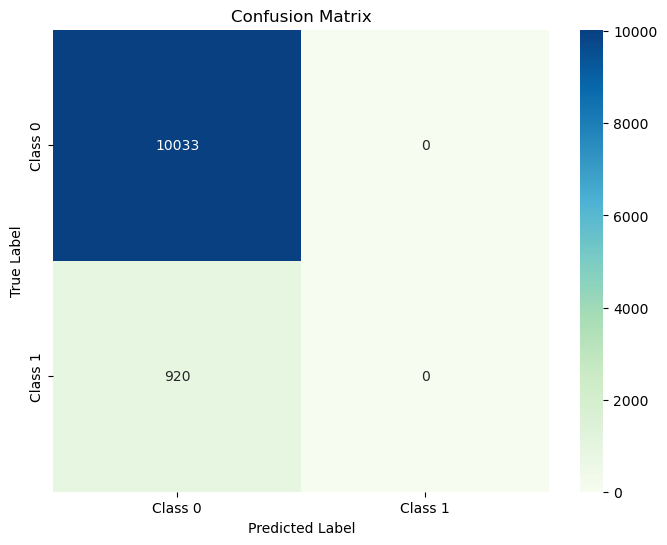

In [8]:
...

# Train majority classifier
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train_scaled, y_train)

dummy_train_pred = dummy_classifier.predict(X_train_scaled)

dummy_test_pred = dummy_classifier.predict(X_test_scaled)



# Print accuracy and confusion matrix results
print(f"Dummy Training Accuracy: {accuracy_score(y_train, dummy_train_pred)}")
print("\nDummy Confusion Matrix:")
cm = confusion_matrix(y_test, dummy_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'GnBu',
xticklabels=['Class 0', 'Class 1'],
yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [9]:
# Logistic classifier AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)



print(f"Logistic AUC: {roc_auc}")

Logistic AUC: 0.9180644091888075


In [10]:
# Dummy classifier AUC
dummy_pred_prob = dummy_classifier.predict_proba(X_test_scaled)[:, 1]
dummy_roc_auc = roc_auc_score(y_test, dummy_pred_prob)

print(f"Dummy AUC: {dummy_roc_auc}")

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

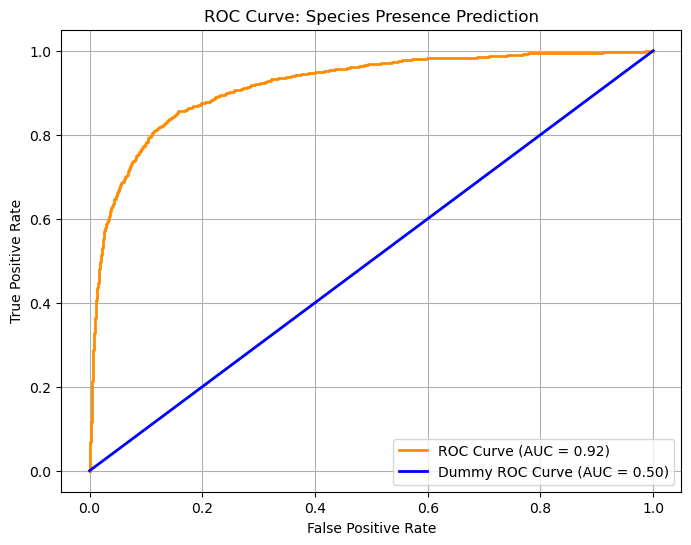

In [11]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

d_fpr, d_tpr, _ = roc_curve(y_test, dummy_pred_prob)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2,
        label = f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot(d_fpr, d_tpr, color = 'blue', lw = 2,
        label = f'Dummy ROC Curve (AUC = {dummy_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Species Presence Prediction')
plt.legend()
plt.grid(True)
plt.show()


How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

On AUC, the two models are drastically different. Even though both models had a similar accuracy of about 0.92, the AUCs are very different. This implies that evaluating classifiers based on the accuracy of their predictions is not very effective. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [13]:
# Define coefficients 
coefficients = model.coef_[0]

# Define features
features = X.columns

# Create a dataframe for the feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})
# Print the sorted feature importance
print(importance_df.sort_values('Coefficient'))

             Feature  Coefficient
4            CR_post    -2.494974
2               HT_m    -1.165414
5     YrFireName_cat    -0.660497
7  Genus_species_cat    -0.067867
0       Times_burned     0.000000
3             CR_pre     0.123414
1             DBH_cm     0.421324
6        Species_cat     0.541509


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

The most important features in determining if a tree will or will not dieare CR_post(post fire live crown ratio) and HT_m (pre-fire tree height). Because a tree is considered dead when there is no more green foliage in the crown (as stated in the methods), it makese sense that its crown ratio would be a strong feature in determining its future status. Height can also affect the tree's likelihood of its crown catching fire. This implies that shorter trees may be more at risk to dying, so perhaps forest managers can put more resources into protecting or preserving smaller trees. 